# Setup 

In [1]:
!pip install rasterio

In [2]:
!pip install git+https://github.com/usgs/geomag-algorithms.git

  Cloning https://github.com/usgs/geomag-algorithms.git to /tmp/pip-req-build-kfobhcpd
  Running command git clone -q https://github.com/usgs/geomag-algorithms.git /tmp/pip-req-build-kfobhcpd
  Stored in directory: /tmp/pip-ephem-wheel-cache-kzv86v0e/wheels/dc/8b/cb/0141ac2aa76db65e2037c96bf61b63c26a64a1eb4ddb6f7eeb
Successfully built geomag-algorithms


In [3]:
!pip install git+https://github.com/samiriff/scikit-dataaccess-ode.git --upgrade

  Cloning https://github.com/samiriff/scikit-dataaccess-ode.git to /tmp/pip-req-build-rz5ahpmp
  Running command git clone -q https://github.com/samiriff/scikit-dataaccess-ode.git /tmp/pip-req-build-rz5ahpmp
  Stored in directory: /tmp/pip-ephem-wheel-cache-a8fb603e/wheels/94/32/44/d60e0ce15a9593baec955d92a45977ccf9869316c9e698efa7
Successfully built scikit-dataaccess
  Found existing installation: scikit-dataaccess 1.9.17.post2
    Uninstalling scikit-dataaccess-1.9.17.post2:
      Successfully uninstalled scikit-dataaccess-1.9.17.post2


# LBL File Reader

In [0]:
from __future__ import unicode_literals, print_function, absolute_import, division
import numpy as np
import re

__version__ = '0.1.1'

class LBLReader:
  
  def __init__(self):
    self._map = {}

  def read(self, fname):
      '''reads in a lbl file named fname to a list'''
      lines = open(fname, 'r').readlines()
      if len(lines) == 0:
          raise ValueError('This lbl file is empty')
      stringpairs = []
      for line in lines:
        tokens = line.split('=')
        if (len(tokens) >= 2):
          stringpairs.append([])
        for token in tokens:
          if token.strip().startswith('/*'):
            continue
          stringpair = stringpairs[-1]
          if len(stringpair) <= 1:
            stringpair.append(token.strip())
          else:
            stringpair[-1] += ' ' + token.strip()
      
      self.process(stringpairs)

  def process(self, stringpairs):
      for stringpair in stringpairs:
        self._map[stringpair[0]] = stringpair[1] if len(stringpair) > 1 else ''

  def get(self, key):
      return self._map[key] if key in self._map else None

## Autocropper

In [0]:
# Autocroppy, designed to remove black borders from scanned documents - https://github.com/gerwin3/autocroppy

class AutoCropper:
    img = None
    
    max_border_size = 300   # maximum border to remove after initial crop (so not guaranteed!)
    safety_margin = 4       # extra border removed to make sure we have no black pixels
    tolerance = 4           # maximum gray-value to consider black
    
    def __init__(self, img):
        self.img = img

    def __borders_left_top(self, img):
        c = self.max_border_size
        while c > 0:
            if img[c, c] < self.tolerance and img[c-1,c-1] < self.tolerance and img[c-2,c-2] < self.tolerance:
                return c, c
            c -= 1 
        return 0, 0
    
    def __borders_left_bottom(self, img):
        c = self.max_border_size
        while c > 0:
            if img[-c, c] < self.tolerance and img[-(c-1), c-1] < self.tolerance and img[-(c-2), c-2] < self.tolerance:
                return c, img.shape[0]-c
            c -= 1
        return 0, img.shape[0]
    
    def __borders_right_top(self, img):
        c = self.max_border_size
        while c > 0:
            if img[c, -c] < self.tolerance and img[c-1, -(c-1)] < self.tolerance and img[c-2, -(c-2)] < self.tolerance:
                return img.shape[1]-c, c
            c -= 1
        return img.shape[1], 0
    
    def __borders_right_bottom(self, img):
        c = self.max_border_size
        while c > 0:
            if img[-c, -c] < self.tolerance and img[-(c-1), -(c-1)] < self.tolerance and img[-(c-2), -(c-2)] < self.tolerance:
                return img.shape[1]-c, img.shape[0]-c
            c -= 1
        return img.shape[1], img.shape[0]
    
    # crops the image to remove black borders on the side, this specific
    # algorithm is build to handle rounded corners in, for example, scanned
    # slides or pages
    def autocrop(self):
        
        # apply a tolerance on a gray version of the image to
        # select the non-black pixels
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        _, threshold = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contoursResult = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contoursResult[1]
        
        # find the contour with the highest area, that will be
        # a slightly too big crop of what we need
        max_area = 0
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > max_area:
                max_area = area
                best_cnt = cnt
                
        # crop it like this so we can perform additional operations
        # to further narrow down the crop
        x, y, w, h = cv2.boundingRect(best_cnt)
        gray_crop = gray[y:y+h, x:x+w]
        color_crop = self.img[y:y+h, x:x+w]
        
        # this more complicated cropping algorithm takes the corners
        # of the image and finds the smallest rectangle that doesn't
        # cover any black borders
        left = 0
        right = gray.shape[1]
        top = 0
        bottom = gray.shape[0]
        
        x, y = self.__borders_left_top(gray_crop)
        if x > left:
            left = x
        if y > top:
            top = x
            
        x, y = self.__borders_left_bottom(gray_crop)
        if x > left:
            left = x
        if y < bottom:
            bottom = y
            
        x, y = self.__borders_right_top(gray_crop)
        if x < right:
            right = x
        if y > top:
            top = y
            
        x, y = self.__borders_right_bottom(gray_crop)
        if x < right:
            right = x
        if y < bottom:
            bottom = y
            
        # these are safety value, by removing another two pixels
        # from the sides we make sure to not include any black
        # pixels that don't belong        
        left = max(left + self.safety_margin, 0)
        right = max(right - self.safety_margin, 0)
        top = max(top + self.safety_margin, 0)
        bottom = max(bottom - self.safety_margin, 0)
        
        # apply the calculated value in the final crop
        # and return!
        return color_crop[top:bottom, left:right]

# Using Scikit-Dataaccess to fetch data based on some criteria

In [0]:
from skdaccess.framework.data_class import DataFetcherCache, ImageWrapper
from skdaccess.utilities.ode_util import *

In [0]:
def query_files_urls(target, mission, instrument, product_type,
                     western_lon, eastern_lon, min_lat, max_lat,
                     min_ob_time, max_ob_time, product_id, file_name,
                     number_product_limit, result_offset_number):    
    # Returns a list of products with selected product metadata that meet the query parameters
    query_type = 'product'
    # Controls the return format for product queries or error messages
    output = 'XML'
    # For each product found return the product files and IDS
    results = 'fp'

    query_url = get_query_url(target, mission, instrument, product_type,
                              western_lon, eastern_lon, min_lat, max_lat,
                              min_ob_time, max_ob_time, product_id,
                              query_type, output, results,
                              number_product_limit, result_offset_number)
                
    print('Query URL:', query_url)
    print('\nFiles that will be downloaded (if not previously downloaded):')
    file_urls = get_files_urls(query_url, file_name, print_info = False)    
    return file_urls

## Query Parameters

In [0]:
target = 'mars'                    # Aimed planetary body, i.e., Mars, Mercury, Moon, Phobos, or Venus
mission = 'MRO'                    # Aimed mission, e.g., MGS or MRO                
instrument = 'HIRISE'              # Aimed instrument from the mission, e.g., HIRISE or CRISM
product_type = 'RDRV11'            # Type of product to look for, e.g., DTM or RDRV11
western_lon = 55.18                # Western longitude to look for the data, from 0 to 360
eastern_lon = 55.31                # Eastern longitude to look for the data, from 0 to 360
min_lat = -26.9                    # Minimal latitude to look for the data, from -90 to 90
max_lat = -26.66                   # Maximal latitude to look for the data, from -90 to 90
product_id = '*1530*RED*' # PDS Product Id to look for, with wildcards (*) allowed
min_ob_time = ''                   # Minimal observation time in (even partial) UTC format, e.g., '2017-03-01'
max_ob_time = ''                   # Maximal observation time in (even partial) UTC format, e.g., '2017-03-01'
file_name = '*.(JP2|LBL)'     # File name to look for, with wildcards (*) allowed
number_product_limit = 10          # Maximal number of products to return (100 at most)
result_offset_number = 0           # Offset the return products, to go beyond the limit of 100 returned products
remove_ndv = True                  # Replace the no-data value as mentionned in the label by np.nan

In [9]:
query_results = query_files_urls(target, mission, instrument, product_type,
                                     western_lon, eastern_lon, min_lat, max_lat,
                                     min_ob_time, max_ob_time, product_id, file_name,
                                     number_product_limit, result_offset_number)
print("Number of Files found =", len(query_results.keys()))
query_results

Query URL: http://oderest.rsl.wustl.edu/live2/?target=mars&ihid=MRO&iid=HIRISE&pt=RDRV11&westernlon=55.18&easternlon=55.31&minlat=-26.9&maxlat=-26.66&query=product&results=fp&output=XML&limit=10&offset=0&productid=*1530*RED*

Files that will be downloaded (if not previously downloaded):
Number of Files found = 8


OrderedDict([('http://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_029600_029699/ESP_029670_1530/ESP_029670_1530_RED.JP2',
              ('ESP_029670_1530_RED', 'PRODUCT DATA FILE')),
             ('http://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_029600_029699/ESP_029670_1530/ESP_029670_1530_RED.LBL',
              ('ESP_029670_1530_RED', 'PRODUCT LABEL FILE')),
             ('http://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_029800_029899/ESP_029815_1530/ESP_029815_1530_RED.JP2',
              ('ESP_029815_1530_RED', 'PRODUCT DATA FILE')),
             ('http://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_029800_029899/ESP_029815_1530/ESP_029815_1530_RED.LBL',
              ('ESP_029815_1530_RED', 'PRODUCT LABEL FILE')),
             ('http://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_030000_030099/ESP_030092_1530/ESP_030092_1530_RED.JP2',
              ('ESP_030092_1530_RED', 'PRODUCT DATA FILE')),
             ('http://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_030000_030099/ESP_030092_1530/ESP_030092_1530_R

## Download JP2 files corresponding to a given bin type (1, 2 or 4)

In [0]:
import urllib.request 

In [0]:
bin_type = 1         # Type of binning used in image - Bin1 = 0.35 cm/pixel, Bin2 = 2xBin1, Bin4 = 2xBin2

In [0]:
def get_bin_type(binning):
  if binning.startswith('(-9998'):
    return 1
  if binning.startswith('(2'):
    return 2
  if binning.startswith('(4'):
    return 4
  return None

### Read the LBL files to select only those Products that match the given bin type

In [13]:
required_products = set()
lblReader = LBLReader()

for query_result in query_results.keys():
  product_name, product_type = query_results[query_result]
  if (product_type == 'PRODUCT LABEL FILE'):
    filename = query_result.split('/')[-1]
    urllib.request.urlretrieve (query_result, filename)
    lblReader.read(filename)
    binning = lblReader.get('MRO:BINNING')
    if get_bin_type(binning) == bin_type:
      required_products.add(product_name)

required_products



{'ESP_048698_1530_RED'}

### Select all the images that have to be downloaded because they match the given bin type

In [14]:
product_image_urls = []
for query_result in query_results.keys():
  product_name, product_type = query_results[query_result]
  if product_type == 'PRODUCT DATA FILE' and product_name in required_products:
    product_image_urls.append((query_result, product_name))
product_image_urls

[('http://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_048600_048699/ESP_048698_1530/ESP_048698_1530_RED.JP2',
  'ESP_048698_1530_RED')]

### Download all selected images

In [0]:
product_image_url = "https://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_048600_048699/ESP_048607_1190/ESP_048607_1190_RED.JP2"

In [16]:
for product_image_url, product_name in product_image_urls:
  print("Downloading", product_image_url)
  !wget {product_image_url}

--2019-06-14 07:21:50--  http://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_048600_048699/ESP_048698_1530/ESP_048698_1530_RED.JP2
Resolving hirise.lpl.arizona.edu (hirise.lpl.arizona.edu)... 128.196.250.179, 2607:f088:0:2::2a
Connecting to hirise.lpl.arizona.edu (hirise.lpl.arizona.edu)|128.196.250.179|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_048600_048699/ESP_048698_1530/ESP_048698_1530_RED.JP2 [following]
--2019-06-14 07:21:51--  https://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_048600_048699/ESP_048698_1530/ESP_048698_1530_RED.JP2
Connecting to hirise.lpl.arizona.edu (hirise.lpl.arizona.edu)|128.196.250.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101831062 (97M) [image/jp2]
Saving to: ‘ESP_048698_1530_RED.JP2.1’

ESP_048698_1530_RED 100%[===================>]  97.11M  16.5MB/s    in 6.7s    

2019-06-14 07:21:58 (14.5 MB/s) - ‘ESP_048698_1530_RED.JP2.1’ saved [10

# Import Required Packages

In [0]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import rasterio
import os
import cv2
import math
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from numpy.lib.stride_tricks import as_strided
from warnings import warn

# Convert JP2 Image into Chunks

## Define Function to slice out multiple 2-D blocks(arrays) from a 2-D array
- Slices out arrays of size (`block_shape, block_shape`) from an array of size (`x, y`)
- Note that you will get an error if either x or y are not perfectly divisible by block_shape

In [0]:
# Based on https://stackoverflow.com/questions/8070349/using-numpy-stride-tricks-to-get-non-overlapping-array-blocks/28207538#28207538 

def view_as_blocks(arr_in, block_shape):
    """Block view of the input n-dimensional array (using re-striding).
    Blocks are non-overlapping views of the input array.
    Parameters
    ----------
    arr_in : ndarray
        N-d input array.
    block_shape : tuple
        The shape of the block. Each dimension must divide evenly into the
        corresponding dimensions of `arr_in`.
    Returns
    -------
    arr_out : ndarray
        Block view of the input array.  If `arr_in` is non-contiguous, a copy
        is made.
    Examples
    --------
    >>> import numpy as np
    >>> from skimage.util.shape import view_as_blocks
    >>> A = np.arange(4*4).reshape(4,4)
    >>> A
    array([[ 0,  1,  2,  3],
           [ 4,  5,  6,  7],
           [ 8,  9, 10, 11],
           [12, 13, 14, 15]])
    >>> B = view_as_blocks(A, block_shape=(2, 2))
    >>> B[0, 0]
    array([[0, 1],
           [4, 5]])
    >>> B[0, 1]
    array([[2, 3],
           [6, 7]])
    >>> B[1, 0, 1, 1]
    13
    >>> A = np.arange(4*4*6).reshape(4,4,6)
    >>> A  # doctest: +NORMALIZE_WHITESPACE
    array([[[ 0,  1,  2,  3,  4,  5],
            [ 6,  7,  8,  9, 10, 11],
            [12, 13, 14, 15, 16, 17],
            [18, 19, 20, 21, 22, 23]],
           [[24, 25, 26, 27, 28, 29],
            [30, 31, 32, 33, 34, 35],
            [36, 37, 38, 39, 40, 41],
            [42, 43, 44, 45, 46, 47]],
           [[48, 49, 50, 51, 52, 53],
            [54, 55, 56, 57, 58, 59],
            [60, 61, 62, 63, 64, 65],
            [66, 67, 68, 69, 70, 71]],
           [[72, 73, 74, 75, 76, 77],
            [78, 79, 80, 81, 82, 83],
            [84, 85, 86, 87, 88, 89],
            [90, 91, 92, 93, 94, 95]]])
    >>> B = view_as_blocks(A, block_shape=(1, 2, 2))
    >>> B.shape
    (4, 2, 3, 1, 2, 2)
    >>> B[2:, 0, 2]  # doctest: +NORMALIZE_WHITESPACE
    array([[[[52, 53],
             [58, 59]]],
           [[[76, 77],
             [82, 83]]]])
    """
    if not isinstance(block_shape, tuple):
        raise TypeError('block needs to be a tuple')

    block_shape = np.array(block_shape)
    if (block_shape <= 0).any():
        raise ValueError("'block_shape' elements must be strictly positive")

    if block_shape.size != arr_in.ndim:
        raise ValueError("'block_shape' must have the same length "
                         "as 'arr_in.shape'")

    arr_shape = np.array(arr_in.shape)
    if (arr_shape % block_shape).sum() != 0:
        raise ValueError("'block_shape' is not compatible with 'arr_in'")

    # -- restride the array to build the block view

    if not arr_in.flags.contiguous:
        warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
                            "array without copying."))

    arr_in = np.ascontiguousarray(arr_in)

    new_shape = tuple(arr_shape // block_shape) + tuple(block_shape)
    new_strides = tuple(arr_in.strides * block_shape) + arr_in.strides

    arr_out = as_strided(arr_in, shape=new_shape, strides=new_strides)

    return arr_out

## Define functions to process and save (`block_shape x block_shape`) image chunks 

In [0]:
# def is_black(img):  
#   width, height = img.shape
#   for row in (20, height - 1):
#     if (img[row][0] == 0):
#       return True
#     if (img[row][width - 20] == 0):
#       return True
  
#   for col in (20, width - 1):
#     if (img[0][col] == 0):
#       return True
#     if (img[height - 20][col] == 0):
#       return True
    
#   return False

In [0]:
def is_black(img, threshold=20):  
  width, height = img.shape
  for row in (height // 2 - threshold, height // 2 + threshold):
    if (img[row][width // 2 - threshold] == 0):
      return True
    if (img[row][width // 2 + threshold] == 0):
      return True
  
  for col in (width // 2 - threshold, width // 2 + threshold):
    if (img[height // 2 - threshold][col] == 0):
      return True
    if (img[height // 2 + threshold][col] == 0):
      return True
    
  return False

In [0]:
def align_image(img):
  img = np.uint8(img)
  img_edges = cv2.Canny(img, 100, 100, apertureSize=3)
  lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)
  if lines is None:
    return img
  
  # print("lines: ", lines)
  angles = []
  
  for x1, y1, x2, y2 in lines[0]:
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angles.append(angle)

  median_angle = np.median(angles)
  img_rotated = ndimage.rotate(img, median_angle)
  return img_rotated

In [0]:
def crop_black_margin(img):
  #gray scale conversion first
  img_gray = img # cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #define threshold in 1 for almost black
  ret, thresh = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
  #find the maximum area contour of the filtered image
  _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  
  filter_area = []
  for c in contours:
    if (cv2.contourArea(c) < 200000):#TODO: set automatically with a max function
      continue 
    filter_area.append(c)

  if (len(filter_area) == 0):
      return None
      
  contour = filter_area[0]
  rects = [cv2.boundingRect(cnt) for cnt in contour]
  height,width = img_gray.shape

  #Calculate the combined bounding rectangle points.
  bottom_x = min([x for (x, y, height, width) in rects])
  bottom_y = min([y for (x, y, height, width) in rects])
  top_x = max([x+width for (x, y, height, width) in rects])
  top_y = max([y+height for (x, y, height, width) in rects])

  cropped = img[height - top_y : height - bottom_y, bottom_x : top_x]
  
  return cropped

In [0]:
def align_and_crop(img):
  return crop_black_margin(align_image(img))

In [0]:
def align_and_crop(img):
  ac = AutoCropper(img)
  ac.max_border_size = 200 	# defaults to 300
  ac.safety_margin = 0 		# defaults to 4, removes extra pixels from the sides to make sure no black remains
  ac.tolerance = 10 			# defaults to 4, a gray value is more likely to be considered black when you increase the tolerance

  # go!
  result = ac.autocrop()
  return result

In [0]:
def write_result_blocks(result_blocks, window, product_name, chunk_size, save_dir='test', skip_black_images=False, align_images=False, vectorized_chunks=None):
  for i in range(result_blocks.shape[0]):
    for j in range(result_blocks.shape[1]):
      img = result_blocks[i][j]
      if not skip_black_images or not is_black(img):
        filename = f'{product_name}_img_row_{window.row_off}_col_{window.col_off}_w_{window.width}_h_{window.height}_x_{i}_y_{j}.jpg'
        filepath = './' + save_dir + '/' + filename
        mpimg.imsave(filepath, img, cmap="gray")
        img = mpimg.imread(filepath)
        
        if align_images:
          img = align_and_crop(img)
          img = cv2.resize(img, (chunk_size, chunk_size), cv2.INTER_AREA)
          mpimg.imsave(filepath, img, cmap='gray')
          new_filename = f'{product_name}_img_row_{window.row_off}_col_{window.col_off}_w_{img.shape[1]}_h_{img.shape[0]}_x_{i}_y_{j}.jpg'
          new_filepath = './' + save_dir + '/' + new_filename
          os.rename(filepath, new_filepath)
        
        if vectorized_chunks is not None:
          vectorized_chunks.append(img.astype(np.uint8))

## Function to convert a large JP2 image into multiple smaller JPG images
- Use Rasterio's sliding window technique to read JP2 image in blocks of `1024 x 1024`into memory
- Split each `1024 x 1024` block into chunks of size `chunk_size x chunk_size` .
- Note that blocks at the corners of the JP2 image might be lesser than 1024 pixels in width or height. I skip such blocks since they will cause an error while slicing into chunks
- TODO: Note that the output consists only of grayscale chunks. I am unable to figure out how to slice a 3-D array

In [0]:
# Based on the idea provided here - https://gis.stackexchange.com/questions/158527/reading-raster-files-by-block-with-rasterio
def chunkify(img_file, product_name, chunk_size=256, save_dir='test', skip_black_images=True, align_images=False, vectorized_chunks=None):
  with rasterio.open(img_file) as src:
    print('Resolution =', src.width, 'x', src.height)
    print('Estimated number of iterations =', ((src.width * src.height) / (1024 * 1024))*1.085)
    
    for block_index, window in tqdm(src.block_windows(1)):
      block_array = src.read(window=window)
      # print('Block array', block_array.shape)
      
      block_array = np.moveaxis(block_array, 0, -1)
      # print('Move axis', block_array.shape)
      
      if block_array.shape[2] != 1:
        block_array = cv2.cvtColor(block_array, cv2.COLOR_RGB2GRAY)
      else:
        block_array = np.squeeze(block_array)
      block_array_shape = block_array.shape
      
      # plt.imshow(block_array, cmap='gray')      
      # print('Grayscale Block Shape', block_array_shape)

      if (block_array_shape[0] % chunk_size == 0 and block_array_shape[1] % chunk_size == 0):
        result_blocks = view_as_blocks(block_array, block_shape=(chunk_size, chunk_size))
        write_result_blocks(result_blocks, window, product_name, chunk_size, save_dir, skip_black_images, align_images, vectorized_chunks)  

In [0]:
# Delete all chunks -- Uncomment only for testing purposes
!rm -r chunks*

In [0]:
def chunkify_all(save_dir_prefix, chunk_size, product_image_urls, skip_black_images=True, align_images=False, save_npz=False):
  vectorized_chunks = None
  if save_npz:
    vectorized_chunks = []
    
  for product_image_url, product_name in product_image_urls:
    filename = product_image_url.split('/')[-1]
    if filename.endswith('JP2'):
      jp2_filename = filename
      chunk_dir = SAVE_DIR_PREFIX + '_' + product_name

      if not os.path.exists(chunk_dir):
        os.makedirs(chunk_dir)     
        
      chunkify(jp2_filename, product_name, CHUNK_SIZE, chunk_dir, SKIP_BLACK_IMAGES, ALIGN_IMAGES, vectorized_chunks)

      print("Number of chunks:", len([name for name in os.listdir(chunk_dir) if os.path.isfile(chunk_dir + '/' + name)]))
  
  if save_npz:
    np.savez_compressed('all_chunks.npz', np.array(vectorized_chunks))

In [130]:
SAVE_DIR_PREFIX = 'chunks'
CHUNK_SIZE = 1024

# Default Settings to Skip all black images
SKIP_BLACK_IMAGES = True  # Set to False to retain all images that contain black pixels
ALIGN_IMAGES = True # Set to True to test Sebastien's rotation of images with black margin

# Uncomment the following lines to Keep black images and use Sebastien's rotation logic to align images 
#SKIP_BLACK_IMAGES = False
#ALIGN_IMAGES = True

chunkify_all(SAVE_DIR_PREFIX, CHUNK_SIZE, product_image_urls, SKIP_BLACK_IMAGES, ALIGN_IMAGES, True)

Resolution = 9475 x 61255
Estimated number of iterations = 600.5519586801529


Number of chunks: 120


## View Sample Chunks

In [139]:
num_chunks = len(os.listdir(chunk_dir))
num_chunks

120

./chunks_ESP_048698_1530_RED/ESP_048698_1530_RED_img_row_20480_col_4096_w_1024_h_1024_x_0_y_0.jpg (1024, 1024, 3)
./chunks_ESP_048698_1530_RED/ESP_048698_1530_RED_img_row_17408_col_3072_w_1024_h_1024_x_0_y_0.jpg (1024, 1024, 3)
./chunks_ESP_048698_1530_RED/ESP_048698_1530_RED_img_row_58368_col_7168_w_1024_h_1024_x_0_y_0.jpg (1024, 1024, 3)
./chunks_ESP_048698_1530_RED/ESP_048698_1530_RED_img_row_43008_col_6144_w_1024_h_1024_x_0_y_0.jpg (1024, 1024, 3)


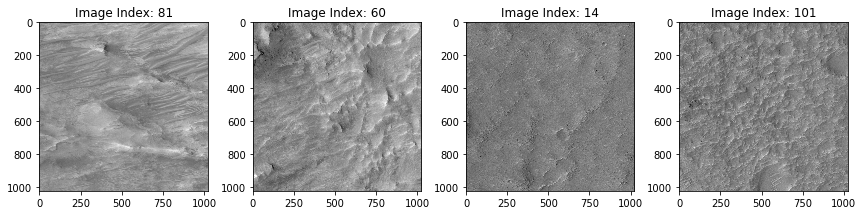

In [143]:
import random
max_images = 4
fig, ax = plt.subplots(1, max_images, figsize=(12, 8))
plt.tight_layout()
for i in range(max_images):
  img_idx = random.randint(0, num_chunks - 1)
  filename = f'./{chunk_dir}/{os.listdir(chunk_dir)[img_idx]}'
  img = mpimg.imread(filename)
  print(filename, img.shape)
  ax[i].set_title('Image Index: ' + str(img_idx))
  ax[i].imshow(img)

### Loading NPZ File

In [141]:
data = np.load('all_chunks.npz', allow_pickle=True)
data[data.files[0]].shape

(120, 1024, 1024, 3)

(1024, 1024, 3)


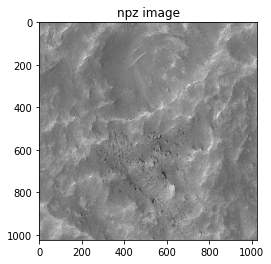

In [142]:
img=data[data.files[0]][0]
print(img.shape)
plt.title('npz image')
plt.imshow(img, cmap='gray')

In [0]:
files.download('all_chunks.npz')

## End of Pipeline

#### Converting Images to .npz file

In [0]:
from google.colab import files
import PIL
import numpy
from tqdm import tqdm 

#get list of images
image_list = os.listdir(chunk_dir)

#make images directory the working directory
os.chdir(chunk_dir)

In [64]:
#initialize empty numpy that will contain all our image vectors
dataset_vectorized = numpy.zeros(shape=(len(image_list), 1024, 1024))


for i in tqdm(range(len(image_list))):
  image_vector = mpimg.imread(image_list[i])
  dataset_vectorized[i] = cv2.cvtColor(image_vector, cv2.COLOR_RGB2GRAY)

100%|██████████| 120/120 [00:02<00:00, 45.49it/s]


In [68]:
#Saves and downloads to .npz the image vectors
np.savez_compressed('hirise_dataset_vectorized.npz',dataset_vectorized)
files.download('hirise_dataset_vectorized.npz')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 41154, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

#### Load .npz file into a numpy array

In [0]:
from numpy import load

data = load('hirise_dataset_vectorized.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])
    loaded_npz=data[item]